#### hello maize
- Maizeを実際に使ってみましょう
- 以下のコードはExampleというノードを2つワークフローに追加し最後にそれをConcatするという例です。
- オリジナルのノードはNodeクラスを継承することで作成できます。
- ワークフローはpythonでプログラム的に定義することもできるし（最も柔軟なアプローチ）、ツリーベースのシリアライゼーションフォーマット（JSON、YAML、TOML）で記述することもできます。
- その後、python内で実行したり、コマンドラインツールとして公開して他のパイプラインに統合したりすることができます。
- airflow*や*luigi*のようなパイプラインツールとは対照的に、maizeはサイクルや条件分岐を含む任意のトポロジーでワークフローを実行できます。

In [ ]:
#import setenv # XDG_CONFIG_HOMEの設定がうまく行かない場合
from maize.core.interface import Parameter, Output, MultiInput
from maize.core.node import Node
from maize.core.workflow import Workflow

#### Nodeの定義
- 任意のノードを作成する場合はNodeクラスを継承して作成します。
- 下の例ではExampleノードはdataというパラメータ（文字列）を受け取り次のノードに渡すという動作をします。ConcatAndPrintは複数ノードからの入力を受け取り、一つの文字列にまとめるという動作をします。

In [2]:
class Example(Node):
    data: Parameter[str] = Parameter(default="Hello")
    out: Output[str] = Output()

    def run(self) -> Node:
        self.out.send(self.data.value)

class ConcatAndPrint(Node):
    inp: MultiInput[str] = MultiInput()

    def run(self):
        result = " ".join(inp.receive() for inp in self.inp)
        self.logger.info("Received: '%s'", result)



#### ワークフローの定義
- ノードの定義ができたのでワークフローを作成しましょう
- Workflowクラスからオブジェクトを作成し、ノードを足していきます。下の例ではExampleノードを２つ足すのでnameをそれぞれにつけています。
- ノードの追加が終わったら今度は各ノードの結合関係を定義します。flow.connectメソッド内にExampleノードのアウトプットがConcatAndPrintの入力になるという定義を書いています。

In [3]:
flow = Workflow(name='hello')
ex1 = flow.add(Example, name='ex1', parameters=dict(data='nice to meet you!'))
ex2 = flow.add(Example, name='ex2', parameters=dict(data='maize'))
concat = flow.add(ConcatAndPrint)
flow.connect(ex1.out, concat.inp)
flow.connect(ex2.out, concat.inp)
flow.check()

#### check and execute
- チェックで問題がない場合は実行プロセスを可視化してその後実行してみましょう。
- 実行プロセスはグラフで表現されます。Pipeline pilotやKnimeを利用されている方にとっては馴染みのある表現かと思います。

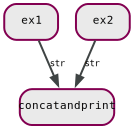

In [4]:
flow.visualize()

In [5]:
flow.execute()

2024-10-28 13:50:56,510 |     INFO |            hello | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-28 13:50:56,510 |     INFO |            hello | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-28 13:5

#### 条件により分岐するワークフロー
- maizeは一定の条件で分岐するというワークフローも構築できます。
- 以下の例ではConditionノードを定義してますがその中で入力の整数値が１０未満かどうかで出力先を変えるという定義をしています。
- out_a, out_bという出力に入力値が渡されるという点を確認してください。

In [6]:
from maize.core.node import Node
from maize.core.interface import Input, Output
from maize.core.workflow import Workflow
from maize.steps.io import LoadData, LogResult
from maize.steps.plumbing import Merge

class Condition(Node):
    inp: Input[int] = Input()
    out_a: Output[int] = Output()
    out_b: Output[int] = Output()

    def run(self) -> None:
        data = self.inp.receive()
        if data < 10:
            self.out_a.send(data)
        else:
            self.out_b.send(data)

- 上の定義により２つ出力ができるのでそれぞれについて受け取り先を定義しています。（LogResultを２つ足している）

In [7]:
flow = Workflow(name="cycle")
load = flow.add(LoadData[int], parameters={"data": 17})
cond = flow.add(Condition)
out_a = flow.add(LogResult, name="out_a")
out_b = flow.add(LogResult, name="out_b")
flow.connect_all(
    (load.out, cond.inp),
    (cond.out_a, out_a.inp),
    (cond.out_b, out_b.inp)
)

In [8]:
flow.check()

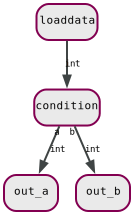

In [9]:
flow.visualize()

In [10]:
flow.execute()

2024-10-28 13:56:46,973 |     INFO |            cycle | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-28 13:56:46,974 |     INFO |            cycle | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-28 13:5

# 繰り返しを含むワークフロー
- Dealyは指定された秒数time.sleepによって処理を止めます。
- Mergeは複数入力をその名のとおりマージします。
- 下の例ではSubGraphというクラスを定義しています。SubGraphはGraphクラスを継承しています。このクラスを継承することで複数のノードをまとめたノードを定義することができます。SubGraphを定義する場合はrunではなくbuildメソッドを定義し内部の関係性を定義します。
- 下のワークフローは値が４８を超えるまでデータに＋２するという動作を繰り返します。
- プログラムでいうループをしたい際などにはこのアプローチが有効であると思います。

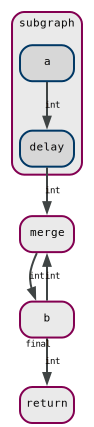

In [11]:
from maize.core.graph import Graph
from maize.core.interface import Parameter, Input, Output
from maize.core.node import Node
from maize.core.workflow import Workflow

from maize.steps.plumbing import Delay, Merge
from maize.steps.io import Return
from typing import TypeVar, Generic
T = TypeVar("T")

class A(Node):
    out: Output[int] = Output()
    send_val: Parameter[int] = Parameter()

    def run(self) -> None:
        self.out.send(self.send_val.value)


class B(Node):
    inp: Input[int] = Input()
    out: Output[int] = Output()
    final: Output[int] = Output()

    def run(self) -> None:
        val = self.inp.receive()
        if val > 48:
            self.logger.debug("%s stopping", self.name)
            self.final.send(val)
            return
        print(val+2)
        self.out.send(val + 2)

class SubGraph(Graph):
    
    def build(self) -> None:
        a = self.add(A, parameters=dict(send_val=36))
        d = self.add(Delay[int], parameters=dict(delay=1))
        self.connect(a.out, d.inp)
        #map_portを使いサブグラフの出力ポートを作成　普通のノードはself.out.send(xxx) etc
        self.out = self.map_port(d.out)
        self.val = self.combine_parameters(a.send_val, name="val")


flow = Workflow(name="test")
sg = flow.add(SubGraph)
b = flow.add(B, loop=True)
merge = flow.add(Merge[int])
ret = flow.add(Return[int])
flow.connect(sg.out, merge.inp)
flow.connect(merge.out, b.inp)
flow.connect(b.out, merge.inp)
flow.connect(b.final, ret.inp)
flow.combine_parameters(sg.val, name="val")
flow.check()
flow.visualize()

In [12]:
flow.execute()

2024-10-28 14:04:18,386 |     INFO |             test | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-28 14:04:18,387 |     INFO |             test | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-28 14:0

38
40


2024-10-28 14:04:22,827 |     INFO |             test | Workflow status
                                   |           return | WAITING_FOR_INPUT
                                   |                b | WAITING_FOR_OUTPUT
                                   |            delay | STOPPED
                                   |                a | COMPLETED
                                   |            merge | RUNNING


42
44


2024-10-28 14:04:24,840 |     INFO |             test | Workflow status
                                   |           return | WAITING_FOR_INPUT
                                   |                b | RUNNING (0 | 1)
                                   |            delay | STOPPED
                                   |                a | COMPLETED
                                   |            merge | RUNNING


46
48


2024-10-28 14:04:27,336 |     INFO |             test | Workflow status
                                   |           return | WAITING_FOR_INPUT
                                   |                b | RUNNING (0 | 1)
                                   |            delay | STOPPED
                                   |                a | COMPLETED
                                   |            merge | WAITING_FOR_INPUT


50


2024-10-28 14:04:28,351 |     INFO |             test | Node 'return' finished (3/5)
2024-10-28 14:04:28,851 |     INFO |             test | Node 'b' finished (4/5)
2024-10-28 14:04:29,340 |     INFO |             test | Node 'merge' finished (5/5)
2024-10-28 14:04:29,842 |     INFO |             test | Execution completed :) total runtime: 0:00:10.936670
	2 nodes completed successfully
	3 nodes stopped due to closing ports
	0 nodes failed
	0:00:32.403994 total walltime
	0:00:20.872141 spent waiting for resources or other nodes
